In [1]:
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import from_unixtime
from pyspark.sql.window import Window
from pyspark.sql import functions as F

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
2,application_1585933145592_0003,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%local
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
df = spark.sql("""select from_unixtime(unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd')) as date, 
sum(confirmed) as numConfirmed, sum(deaths) as numDeaths,sum(recovered) as numRecovered,admin2,province_state, 
concat(admin2, ' - ', province_state) as county 
from covid19.jhu_daily_new
where year='2020' and (month='03' or month='04')
and country_region = 'US' and 
( province_state = 'Virginia' or province_state = 'Maryland' or 
province_state = 'California' or province_state = 'Washington' or province_state = 'District of Columbia' ) 
group by unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd'),admin2,province_state
order by unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd') asc, sum(confirmed) desc""")
df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------------+---------+------------+--------------------+--------------------+--------------------+
|               date|numConfirmed|numDeaths|numRecovered|              admin2|      province_state|              county|
+-------------------+------------+---------+------------+--------------------+--------------------+--------------------+
|2020-03-22 00:00:00|        1040|       75|           0|                King|          Washington|   King - Washington|
|2020-03-22 00:00:00|         480|       10|           0|           Snohomish|          Washington|Snohomish - Washi...|
|2020-03-22 00:00:00|         407|        5|           0|         Los Angeles|          California|Los Angeles - Cal...|
|2020-03-22 00:00:00|         263|        8|           0|         Santa Clara|          California|Santa Clara - Cal...|
|2020-03-22 00:00:00|         164|        0|           0|          Unassigned|          Washington|Unassigned - Wash...|
|2020-03-22 00:00:00|         15

In [4]:
%spark -o df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

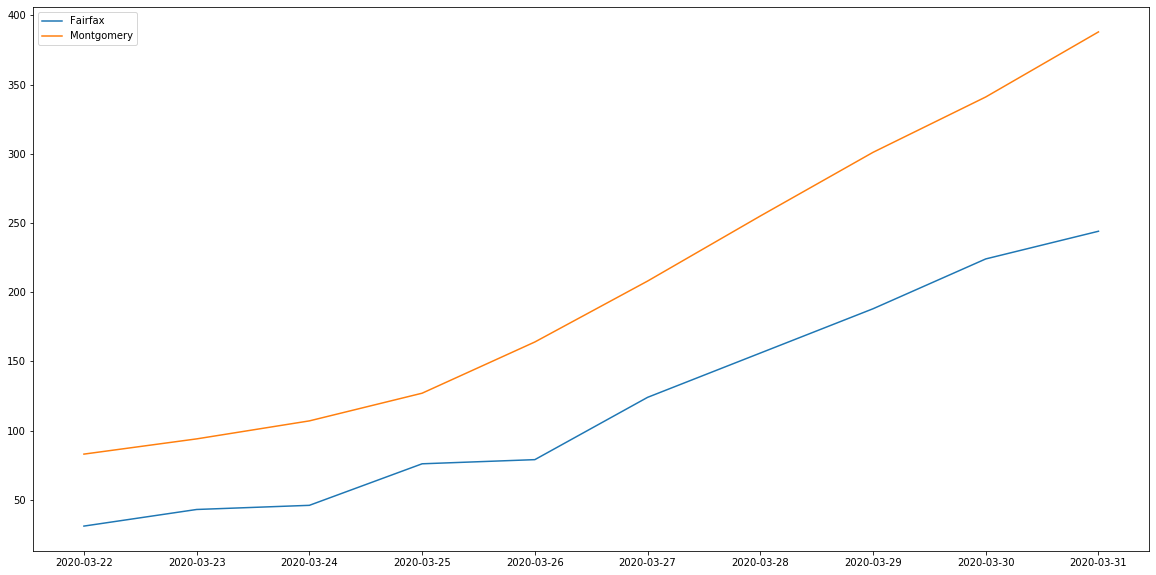

In [5]:
%local
plt.figure(figsize=(20,10))
plt.plot('date','numConfirmed',data=df.loc[(df['admin2'] == 'Fairfax') & (df['province_state'] == 'Virginia')],label="Fairfax")
plt.plot('date','numConfirmed',data=df.loc[(df['admin2'] == 'Montgomery') & (df['province_state'] == 'Maryland')],label="Montgomery")
plt.legend()
plt.show()

In [6]:
df_cumulative = spark.sql("""select sum(confirmed) as numConfirmed, admin2, province_state 
from covid19.jhu_daily_new
where year='2020' and (month='03' or month='04')
and country_region = 'US' and 
( province_state = 'Virginia' or province_state = 'Maryland' or 
( province_state = 'California' and admin2 = 'Los Angeles' ) or 
( province_state = 'Washington' and admin2 = 'King' ) ) 
group by admin2,province_state
order by sum(confirmed) desc""")
df_cumulative.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+---------------+--------------+
|numConfirmed|         admin2|province_state|
+------------+---------------+--------------+
|       21606|           King|    Washington|
|       21461|    Los Angeles|    California|
|        3013|     Montgomery|      Maryland|
|        2429|Prince George's|      Maryland|
|        1827|        Fairfax|      Virginia|
|        1698|      Baltimore|      Maryland|
|        1375| Baltimore City|      Maryland|
|         985|   Anne Arundel|      Maryland|
|         887|         Howard|      Maryland|
|         855|      Arlington|      Virginia|
|         737|     James City|      Virginia|
|         695| Prince William|      Virginia|
|         628|        Loudoun|      Virginia|
|         529| Virginia Beach|      Virginia|
|         502|        Carroll|      Maryland|
|         444|        Henrico|      Virginia|
|         297|        Charles|      Maryland|
|         282|   Chesterfield|      Virginia|
|         244|  Richmond City|    

In [7]:
df_topcounties = spark.sql("""select concat(admin2, ' - ', province_state) as county 
from covid19.jhu_daily_new
where year='2020' and (month='03' or month='04')
and country_region = 'US' and 
( province_state = 'Virginia' or province_state = 'Maryland' or province_state = 'District of Columbia' or 
( province_state = 'California' and admin2 = 'Los Angeles' ) or 
( province_state = 'Washington' and admin2 = 'King' ) ) 
group by admin2,province_state
order by sum(confirmed) desc
limit 20""")
df_topcounties.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|              county|
+--------------------+
|   King - Washington|
|Los Angeles - Cal...|
|District of Colum...|
|Montgomery - Mary...|
|Prince George's -...|
|  Fairfax - Virginia|
|Baltimore - Maryland|
|Baltimore City - ...|
|Anne Arundel - Ma...|
|   Howard - Maryland|
|Arlington - Virginia|
|James City - Virg...|
|Prince William - ...|
|  Loudoun - Virginia|
|Virginia Beach - ...|
|  Carroll - Maryland|
|  Henrico - Virginia|
|  Charles - Maryland|
|Chesterfield - Vi...|
|Richmond City - V...|
+--------------------+

In [8]:
%spark -o df_topcounties

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

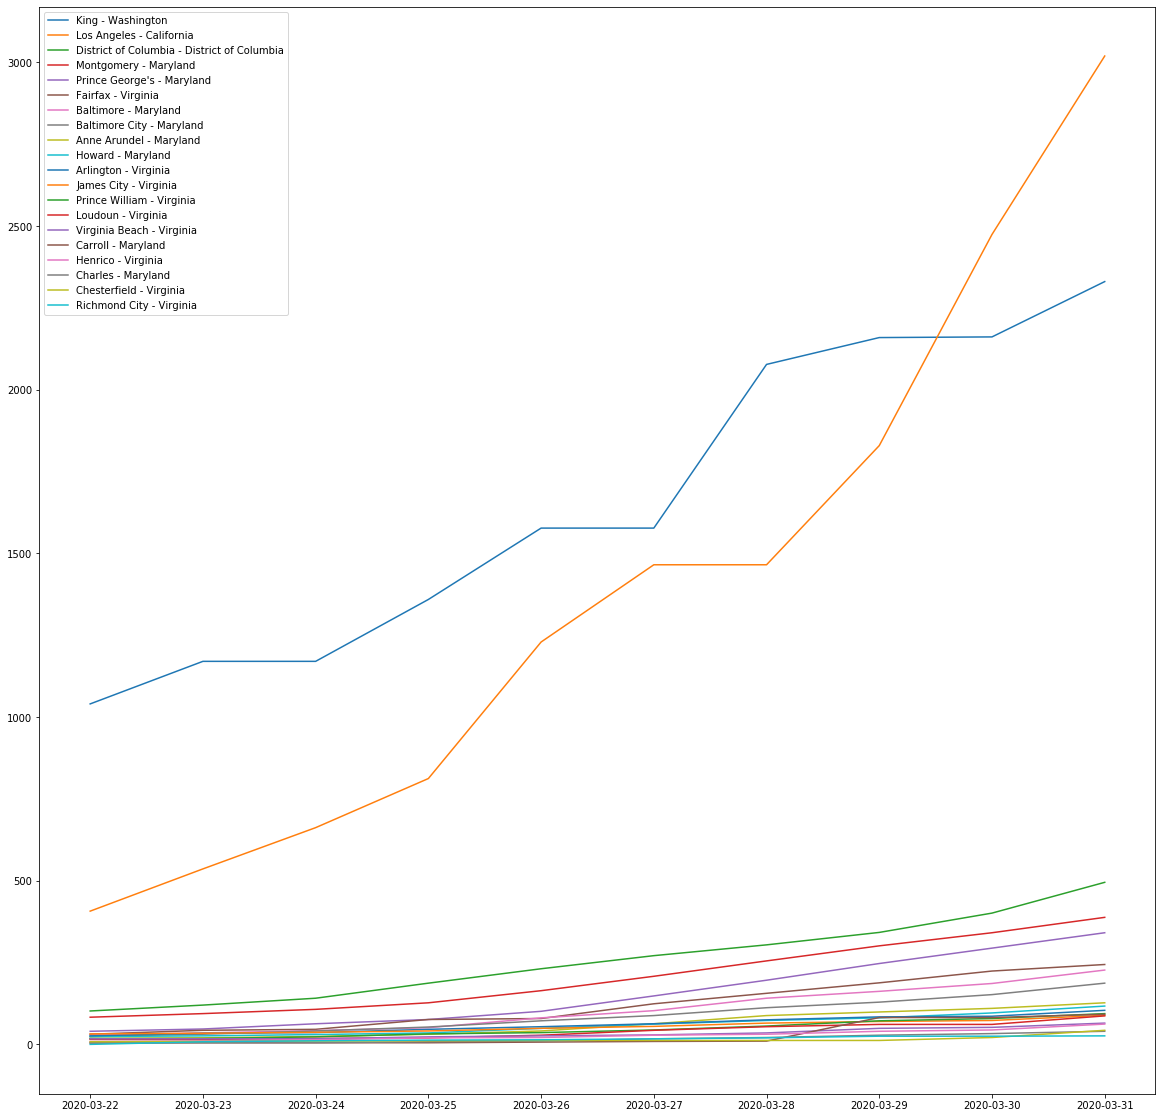

In [9]:
%local
plt.figure(figsize=(20,20))
for index in df_topcounties.index:
  plt.plot('date', 'numConfirmed', data=df.loc[df['county']==df_topcounties['county'][index]],label=df_topcounties['county'][index])
  plt.text
plt.legend()
plt.show()

In [10]:
df_cumulative_dmv = spark.sql("""select sum(confirmed) as numConfirmed, admin2, province_state 
from covid19.jhu_daily_new
where year='2020' and (month='03' or month='04')
and country_region = 'US' and 
( province_state = 'Virginia' or province_state = 'Maryland' or province_state = 'District of Columbia' ) 
group by admin2,province_state
order by sum(confirmed) desc""")
df_cumulative_dmv.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+--------------------+--------------------+
|numConfirmed|              admin2|      province_state|
+------------+--------------------+--------------------+
|        3833|District of Columbia|District of Columbia|
|        3013|          Montgomery|            Maryland|
|        2429|     Prince George's|            Maryland|
|        1827|             Fairfax|            Virginia|
|        1698|           Baltimore|            Maryland|
|        1375|      Baltimore City|            Maryland|
|         985|        Anne Arundel|            Maryland|
|         887|              Howard|            Maryland|
|         855|           Arlington|            Virginia|
|         737|          James City|            Virginia|
|         695|      Prince William|            Virginia|
|         628|             Loudoun|            Virginia|
|         529|      Virginia Beach|            Virginia|
|         502|             Carroll|            Maryland|
|         444|             Henr

In [11]:
%spark -o df_cumulative_dmv

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
df_topcounties_dmv = spark.sql("""select concat(admin2, ' - ', province_state) as county 
from covid19.jhu_daily_new
where year='2020' and (month='03' or month='04')
and country_region = 'US' and 
( province_state = 'Virginia' or province_state = 'Maryland' or province_state = 'District of Columbia' ) 
group by admin2,province_state
order by sum(confirmed) desc
limit 10""")
df_topcounties_dmv.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|              county|
+--------------------+
|District of Colum...|
|Montgomery - Mary...|
|Prince George's -...|
|  Fairfax - Virginia|
|Baltimore - Maryland|
|Baltimore City - ...|
|Anne Arundel - Ma...|
|   Howard - Maryland|
|Arlington - Virginia|
|James City - Virg...|
+--------------------+

In [13]:
%spark -o df_topcounties_dmv

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

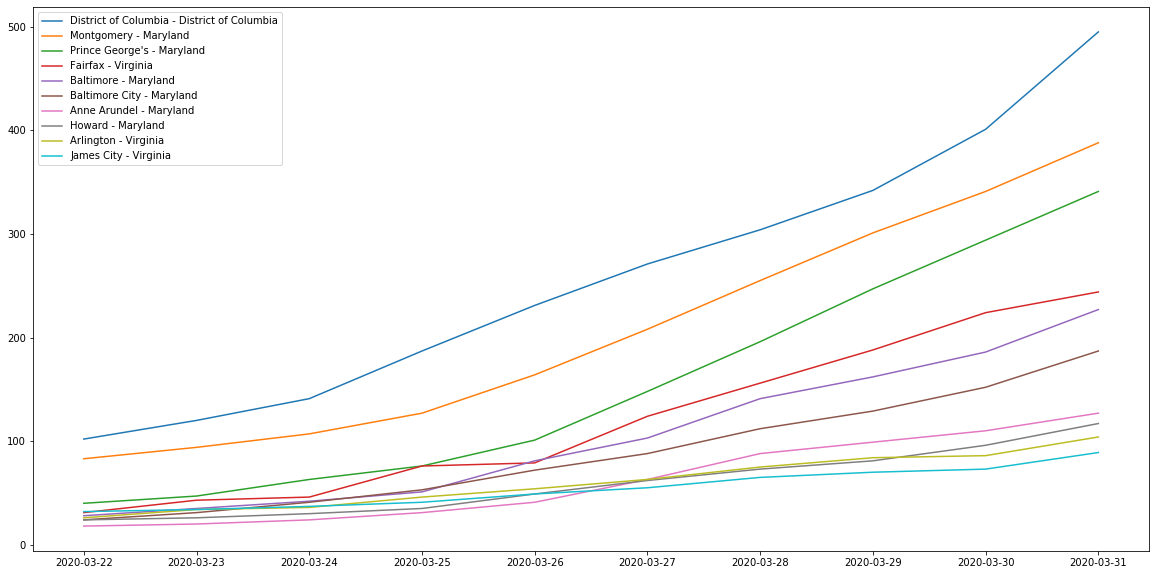

In [17]:
%local
plt.figure(figsize=(20,10))
for index in df_topcounties_dmv.index:
  plt.plot('date', 'numConfirmed', data=df.loc[df['county']==df_topcounties_dmv['county'][index]],label=df_topcounties_dmv['county'][index])
  plt.text
plt.legend()
plt.show()

In [22]:
df_fairfax = spark.sql("""select from_unixtime(unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd')) as date, 
sum(confirmed) as numConfirmed 
from covid19.jhu_daily_new
where year='2020' and (month='03' or month='04')
and country_region = 'US' and 
( province_state = 'Virginia' ) and ( admin2 = 'Fairfax' ) 
group by unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd'),admin2,province_state
order by unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd') asc, sum(confirmed) desc""")
df_fairfax.show()

my_window = Window.partitionBy().orderBy("date")

df_fairfax = df_fairfax.withColumn("dayBefore", F.lag(df_fairfax.numConfirmed).over(my_window))
df_fairfax = df_fairfax.withColumn("change", F.when(F.isnull(df_fairfax.numConfirmed - df_fairfax.dayBefore), 0).otherwise(df_fairfax.numConfirmed - df_fairfax.dayBefore))

df_fairfax.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------------+
|               date|numConfirmed|
+-------------------+------------+
|2020-03-22 00:00:00|          31|
|2020-03-23 00:00:00|          43|
|2020-03-24 00:00:00|          46|
|2020-03-25 00:00:00|          76|
|2020-03-26 00:00:00|          79|
|2020-03-27 00:00:00|         124|
|2020-03-28 00:00:00|         156|
|2020-03-29 00:00:00|         188|
|2020-03-30 00:00:00|         224|
|2020-03-31 00:00:00|         244|
|2020-04-01 00:00:00|         288|
|2020-04-02 00:00:00|         328|
+-------------------+------------+

+-------------------+------------+---------+------+
|               date|numConfirmed|dayBefore|change|
+-------------------+------------+---------+------+
|2020-03-22 00:00:00|          31|     null|     0|
|2020-03-23 00:00:00|          43|       31|    12|
|2020-03-24 00:00:00|          46|       43|     3|
|2020-03-25 00:00:00|          76|       46|    30|
|2020-03-26 00:00:00|          79|       76|     3|
|2020-03-27 00:00:00|  

In [23]:
%spark -o df_fairfax

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

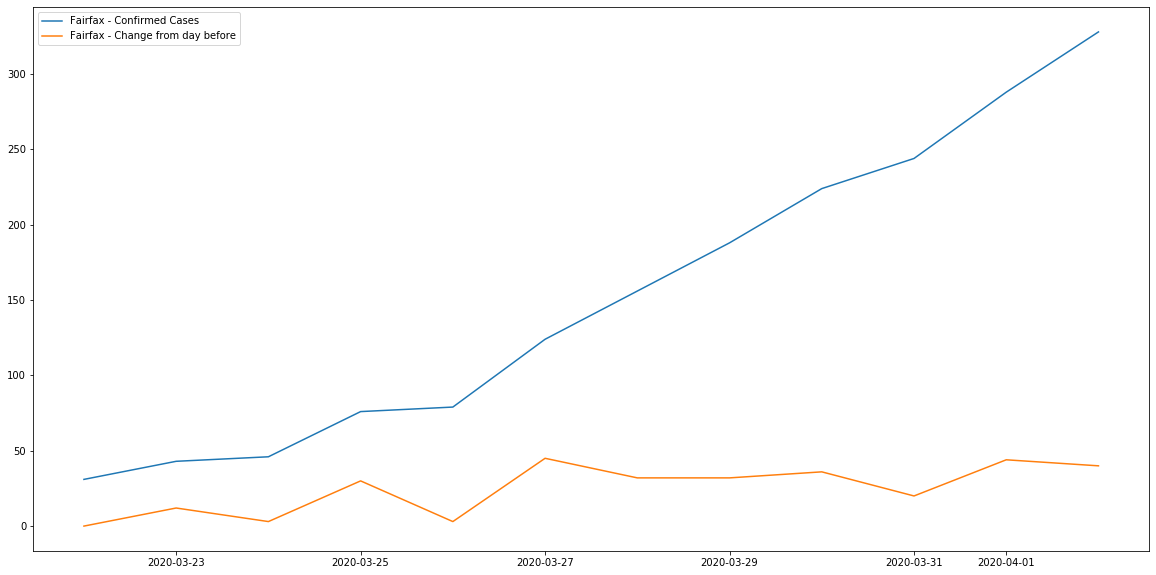

In [24]:
%local
plt.figure(figsize=(20,10))
plt.plot('date', 'numConfirmed', data=df_fairfax, label="Fairfax - Confirmed Cases")
plt.plot('date', 'change', data=df_fairfax, label="Fairfax - Change from day before")
plt.text
plt.legend()
plt.show()